In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

from dataset import *

# This is a hack to be able to import modules in parent directory
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [19]:
datasets = {
            0: deepmatcher_structured_amazon_google,
            1: deepmatcher_structured_dblp_acm,
            2: deepmatcher_structured_dblp_google_scholar,
            3: deepmatcher_structured_itunes_amazon,
            4: deepmatcher_structured_walmart_amazon,
            5: deepmatcher_textual_abt_buy,
}

def save_plots(models=['.'], specific=None, x='labeled_instances', y='test_f1', experiments=[0,1,3,5,6], include_max=False, min_labeled=200, file='results'):
    """
    Main function for saving plots based on test results
    params:
    models: list of folder names you want to plot
    specific: specify dataset by key in datasets,
    x: value to use on x-axis
    y: list of values to use on y-axis
    plots: list of predefined experiments to be included
    f1_all: True if you want a red line of maximum f1 score in graph
    """
    exps = [f'exp{nr}' for nr in experiments]
    
    if specific is not None:
        d = datasets[specific]()
        plot_results(models, d, x, y, exps, include_max, min_labeled, file)
       
    else:
        for dataset in datasets.values():
            d = dataset()
            plot_results(models, d, x, y, exps, include_max, min_labeled, result)

def plot_results(models, dataset, x, y, experiments, include_max=False, min_labeled=200, file='results'):
    scores = {}
    max_val = None
    
    for model in models:
        for filename in sorted(glob(f'{model}/out/{dataset.name}/*.csv')):
            if file in filename:
                for exp in experiments:
                    if exp == 'exp0' and exp in filename:
                        df = pd.read_csv(filename)
                        max_val = df.loc[:, y].iloc[-1]
                        scores[f'{model}_{exp}'] = df.loc[df['labeled_instances'] >= min_labeled, :].iloc[:-1]
                    elif exp == 'exp3' and exp in filename:
                        df = pd.read_csv(filename)
                        scores[f'{model}_{exp}'] = df.loc[df['labeled_instances'] >= min_labeled, :].iloc[:-1]
                    elif exp in filename:
                        df = pd.read_csv(filename)
                        scores[f'{model}_{exp}'] = df

    make_plot(scores, x, y, dataset, models, experiments, max_val)
    
def make_plot(scores, x, y, dataset, models, experiments, max_val):
    plt.figure(num=None, figsize=(15, 4), facecolor='w', edgecolor='k') # set size of plot
    titles = []
    
    title_mapping = {
            'exp0': 'random baseline',
            'exp1': 'transformer al',
            'exp3': 'ml-al',
            'exp5': 'uncertainity',
            'exp6': 'kasi proper'
        }
    
    for key,score in scores.items():
        exp = key.split('_')[-1]
        if 'exp6' in key:
            plt.plot(score['orakle_instances'], score[y])
            titles.append(f'{key} ({title_mapping[exp]}) - orakle')

        else:    
            plt.plot(score[x], score[y])
            titles.append(f'{key} ({title_mapping[exp]})')
    
    if max_val:
        plt.axhline(y=max_val, color='r')
        titles.append(f'max')

    #plt.xticks(scores[list(scores.keys())[-1]][x])  # set values of points on x axis
    plt.margins(0.01) # set margins to 0.01
    plt.legend(titles, loc=4) # add titles of plots, 4 = lower right, 2 = upper left
    title = dataset.name.split('/')[-1]
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)

    try:
        path = os.path.join('graps', f'{"_".join(models)}', f'{"_".join(experiments)}')
        os.makedirs(path)
    except OSError as e:
        pass
    
    plt.savefig(f'{path}/{title}_{y}.pdf', format='pdf', bbox_inches='tight')

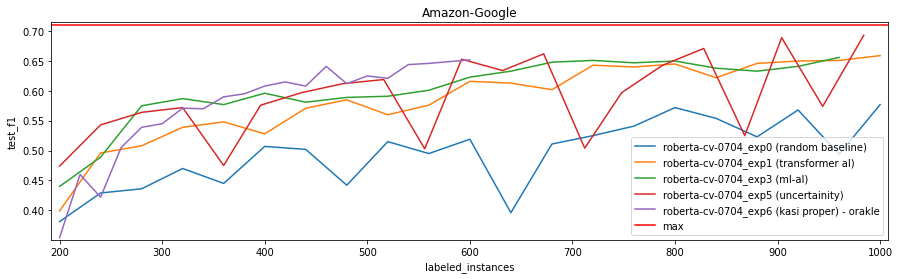

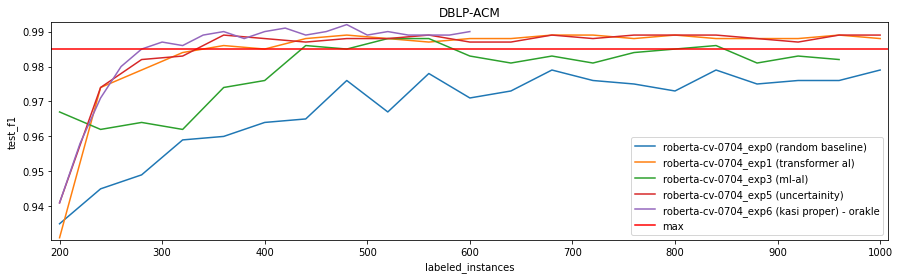

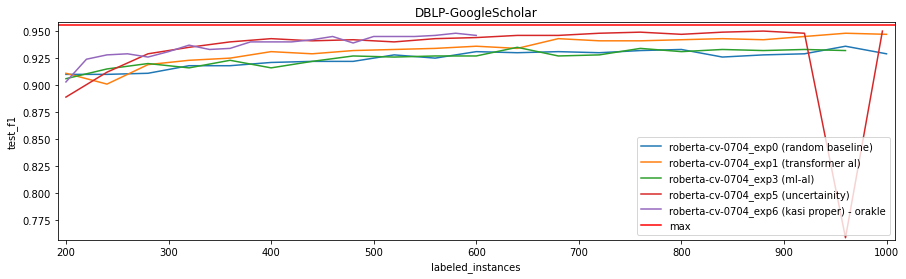

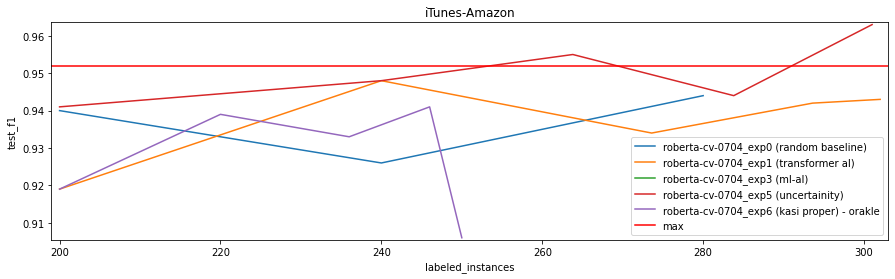

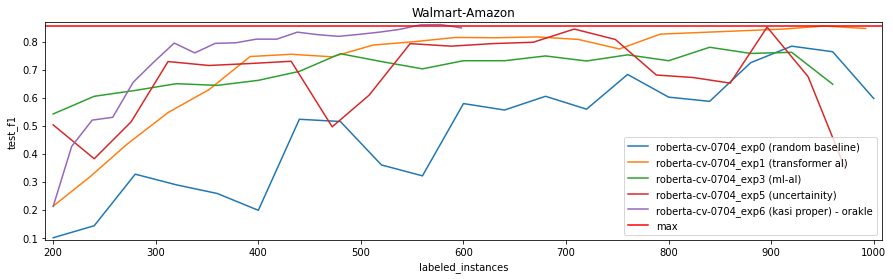

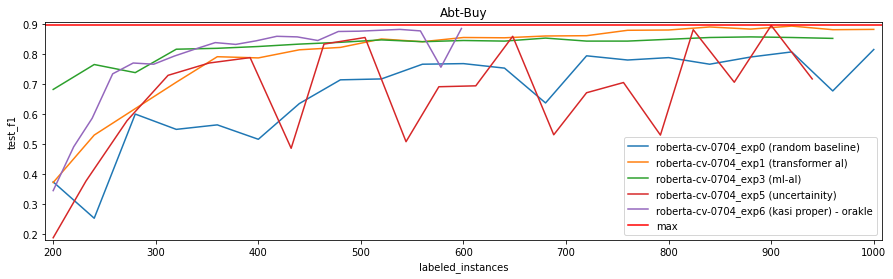

In [20]:
save_plots(models=['roberta-cv-0704'], x='labeled_instances', y='test_f1', experiments=[0,1,3,5,6], specific=None, min_labeled=200, file='results')